In [1]:
# moving XGBoost prediction code to own notebook

In [2]:
# Generic inputs for most ML tasks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
import xgboost as xgb

pd.options.display.float_format = '{:,.2f}'.format
# setup interactive notebook mode
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML

In [3]:
data_set = pd.read_csv("MultipleSources-2019-2025-Ascending.csv")
data_set.head()

,Date,SP500,Futures,Nikkei,FTSE,DAX
0,04/03/19,"2,873.40","2,879.75","21,713.21","7,418.28","11,954.40"
1,04/04/19,"2,879.39","2,882.75","21,724.95","7,401.94","11,988.01"
2,04/05/19,"2,892.74","2,896.00","21,807.50","7,446.87","12,009.75"
3,04/08/19,"2,895.77","2,898.25","21,761.65","7,451.89","11,963.40"
4,04/09/19,"2,878.20","2,882.50","21,802.59","7,425.57","11,850.57"


In [4]:
data_set.columns
# Step 1: Ensure the 'Date' column is in datetime format
data_set['Date'] = pd.to_datetime(data_set['Date'], format='%m/%d/%y')
# Step 2: Convert datetime to integer timestamp (in seconds)
data_set['Date'] = data_set['Date'].astype(np.int64) // 10**9

Index(['Date', 'SP500', 'Futures', 'Nikkei', 'FTSE', 'DAX'], dtype='object')

In [5]:
def add_lag_features(df, columns, lags):
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

lag_columns = ['SP500', 'DAX', 'FTSE', 'Nikkei']
lag_days = [1, 2, 3] 
data_set = add_lag_features(data_set, lag_columns, lag_days)
data_set = data_set.dropna()  # Drop rows with NaNs from lags
data_set.head()
data_set = data_set.sort_values(by='Date').reset_index(drop=True)

,Date,SP500,Futures,Nikkei,FTSE,DAX,SP500_lag_1,SP500_lag_2,SP500_lag_3,DAX_lag_1,DAX_lag_2,DAX_lag_3,FTSE_lag_1,FTSE_lag_2,FTSE_lag_3,Nikkei_lag_1,Nikkei_lag_2,Nikkei_lag_3
3,1554681600,"2,895.77","2,898.25","21,761.65","7,451.89","11,963.40","2,892.74","2,879.39","2,873.40","12,009.75","11,988.01","11,954.40","7,446.87","7,401.94","7,418.28","21,807.50","21,724.95","21,713.21"
4,1554768000,"2,878.20","2,882.50","21,802.59","7,425.57","11,850.57","2,895.77","2,892.74","2,879.39","11,963.40","12,009.75","11,988.01","7,451.89","7,446.87","7,401.94","21,761.65","21,807.50","21,724.95"
5,1554854400,"2,888.21","2,894.50","21,687.57","7,421.91","11,905.91","2,878.20","2,895.77","2,892.74","11,850.57","11,963.40","12,009.75","7,425.57","7,451.89","7,446.87","21,802.59","21,761.65","21,807.50"
6,1554940800,"2,888.32","2,891.75","21,711.38","7,417.95","11,935.20","2,888.21","2,878.20","2,895.77","11,905.91","11,850.57","11,963.40","7,421.91","7,425.57","7,451.89","21,687.57","21,802.59","21,761.65"
7,1555027200,"2,907.41","2,912.50","21,870.56","7,437.06","11,999.93","2,888.32","2,888.21","2,878.20","11,935.20","11,905.91","11,850.57","7,417.95","7,421.91","7,425.57","21,711.38","21,687.57","21,802.59"


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_set.drop(columns = ['SP500']), data_set['SP500'], test_size=0.2, random_state=50)
X_train
X_test
y_train
y_test

,Date,Futures,Nikkei,FTSE,DAX,SP500_lag_1,SP500_lag_2,SP500_lag_3,DAX_lag_1,DAX_lag_2,DAX_lag_3,FTSE_lag_1,FTSE_lag_2,FTSE_lag_3,Nikkei_lag_1,Nikkei_lag_2,Nikkei_lag_3
227,1595376000,"3,265.50","22,751.61","6,207.10","13,104.25","3,257.30","3,251.84","3,224.73","13,171.83","13,046.92","12,919.61","6,269.73","6,261.52","6,290.30","22,884.22","22,717.48","22,696.42"
932,1716508800,"5,321.50","38,646.11","8,317.59","18,693.37","5,267.84","5,307.01","5,321.41","18,691.32","18,680.20","18,726.76","8,339.23","8,370.33","8,416.45","39,103.22","38,617.10","38,946.93"
394,1624492800,"4,256.00","28,875.23","7,109.97","15,589.23","4,241.84","4,246.44","4,224.79","15,456.39","15,636.33","15,603.24","7,074.06","7,090.01","7,062.29","28,874.89","28,884.13","28,010.93"
550,1651104000,"4,283.50","26,847.90","7,509.19","13,979.84","4,183.96","4,175.20","4,296.12","13,793.94","13,756.40","13,924.17","7,425.61","7,386.19","7,380.54","26,386.63","26,700.11","26,590.78"
285,1605657600,"3,565.00","25,728.14","6,385.24","13,201.89","3,609.53","3,626.91","3,585.15","13,133.47","13,138.61","13,076.72","6,365.33","6,421.29","6,316.39","26,014.62","25,906.93","25,385.87"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,1744156800,"5,491.00","31,714.03","7,679.48","19,670.88","4,982.77","5,062.25","5,074.08","20,280.26","19,789.62","20,641.72","7,910.53","7,702.08","8,054.98","33,012.58","31,136.58","33,780.58"
229,1596153600,"3,263.50","21,710.00","5,897.76","12,313.36","3,246.22","3,258.44","3,218.44","12,379.65","12,822.26","12,835.28","5,989.99","6,131.46","6,129.26","22,339.23","22,397.11","22,657.38"
70,1566432000,"2,922.25","20,628.01","7,128.18","11,747.04","2,924.43","2,900.51","2,923.65","11,802.85","11,651.18","11,715.37","7,203.97","7,125.00","7,189.65","20,618.57","20,677.22","20,563.16"
132,1579651200,"3,319.75","24,031.35","7,571.92","13,515.75","3,320.79","3,329.62","3,316.81","13,555.87","13,526.13","13,429.43","7,610.70","7,674.56","7,609.81","23,864.56","24,041.26","23,933.13"


,Date,Futures,Nikkei,FTSE,DAX,SP500_lag_1,SP500_lag_2,SP500_lag_3,DAX_lag_1,DAX_lag_2,DAX_lag_3,FTSE_lag_1,FTSE_lag_2,FTSE_lag_3,Nikkei_lag_1,Nikkei_lag_2,Nikkei_lag_3
243,1598400000,"3,480.25","23,290.86","6,045.60","13,190.15","3,443.62","3,431.28","3,397.16","13,061.62","13,066.54","12,764.80","6,037.01","6,104.73","6,001.89","23,296.77","22,985.51","22,920.30"
849,1701388800,"4,600.75","33,431.51","7,529.35","16,397.52","4,567.80","4,550.58","4,554.89","16,215.43","16,166.45","15,992.67","7,453.75","7,423.46","7,455.24","33,486.89","33,321.22","33,408.39"
759,1687305600,"4,409.25","33,575.14","7,559.18","16,023.13","4,388.71","4,409.59","4,425.84","16,111.32","16,357.63","16,290.12","7,569.31","7,642.72","7,628.26","33,388.91","33,706.08","33,485.49"
445,1633392000,"4,334.00","27,822.12","7,077.10","15,194.49","4,300.46","4,357.04","4,307.54","15,036.55","15,156.44","15,260.69","7,011.01","7,027.07","7,086.42","28,444.89","28,771.07","29,452.66"
345,1616457600,"3,899.75","28,995.92","6,699.19","14,662.02","3,940.59","3,913.10","3,915.46","14,657.21","14,621.00","14,775.52","6,726.10","6,708.71","6,779.68","29,174.15","29,792.05","30,216.75"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,1709856000,"5,129.00","39,688.94","7,659.74","17,814.51","5,157.36","5,104.76","5,078.65","17,842.85","17,716.71","17,698.40","7,692.46","7,679.31","7,646.16","39,598.71","40,090.78","40,097.63"
691,1675987200,"4,099.75","27,670.98","7,882.45","15,307.98","4,081.50","4,117.86","4,164.00","15,523.42","15,412.05","15,320.88","7,911.15","7,885.17","7,864.71","27,584.35","27,606.46","27,685.47"
1073,1740960000,"5,860.75","37,785.47","8,871.31","23,147.02","5,954.50","5,861.57","5,956.06","22,551.43","22,550.89","22,794.11","8,809.74","8,756.21","8,731.46","37,155.50","38,256.17","38,142.37"
278,1604880000,"3,544.00","24,839.84","6,186.29","13,095.97","3,509.44","3,510.45","3,443.44","12,480.02","12,568.09","12,324.22","5,910.02","5,906.18","5,883.26","24,325.23","24,105.28","23,695.23"


227    3,276.02
932    5,304.72
394    4,266.49
550    4,287.50
285    3,567.79
         ...   
1096   5,456.90
229    3,271.12
70     2,922.95
132    3,321.75
109    3,140.52
Name: SP500, Length: 879, dtype: float64

243    3,478.73
849    4,594.63
759    4,365.69
445    4,345.72
345    3,910.52
         ...   
895    5,123.69
691    4,090.46
1073   5,849.72
278    3,550.50
744    4,205.52
Name: SP500, Length: 220, dtype: float64

In [7]:
dtrain_reg = xgb.DMatrix(X_train, y_train, )#enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, )#enable_categorical=True)
params = {"objective": "reg:squarederror", "tree_method": "exact", "max_depth" : 4, "learning_rate" : 0.1} # use "tree_method" : "hist" if you need speed

In [8]:
n = 100

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

In [9]:
from sklearn.metrics import mean_squared_error
preds = model.predict(dtest_reg)

In [10]:
test_output = pd.DataFrame(preds, index = X_test.index, columns = ['pred_spx'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_spx'] - test_output['SP500']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
xg = abs(test_output['pred_spx'] - test_output['SP500']).mean()/test_output['SP500'].mean()
print(xg)

XGBmodel = model # for later use

,pred_spx,SP500
243,"3,480.51","3,478.73"
849,"4,579.71","4,594.63"
759,"4,384.38","4,365.69"
445,"4,330.03","4,345.72"
345,"3,907.25","3,910.52"


Mean absolute error is 
11.484481667258507
0.0026930260159918323


['Date',
 'Futures',
 'Nikkei',
 'FTSE',
 'DAX',
 'SP500_lag_1',
 'SP500_lag_2',
 'SP500_lag_3',
 'DAX_lag_1',
 'DAX_lag_2',
 'DAX_lag_3',
 'FTSE_lag_1',
 'FTSE_lag_2',
 'FTSE_lag_3',
 'Nikkei_lag_1',
 'Nikkei_lag_2',
 'Nikkei_lag_3']

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Predicted S&P 500 Closing Prices for Next 7 Days')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Predicted Close Price')

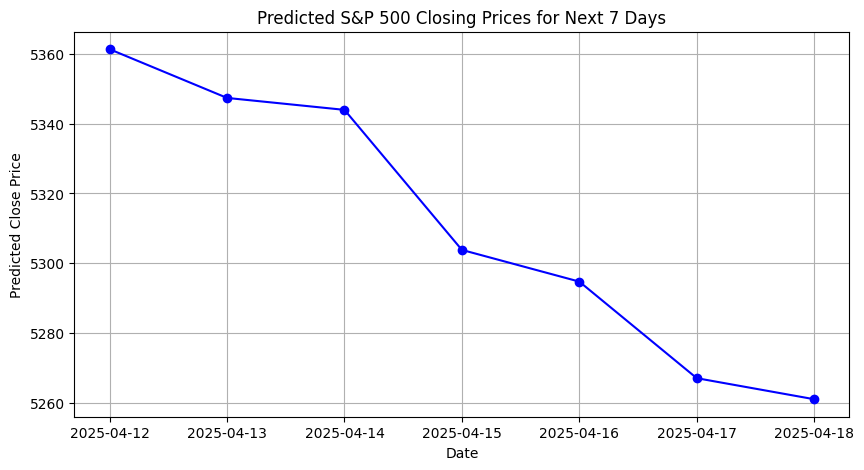

2025-04-12 00:00:00: $5361.35
2025-04-13 00:00:00: $5347.38
2025-04-14 00:00:00: $5343.96
2025-04-15 00:00:00: $5303.80
2025-04-16 00:00:00: $5294.71
2025-04-17 00:00:00: $5267.02
2025-04-18 00:00:00: $5260.99


In [11]:
# Feed last N rows into model, get predictions and use those values
# as input for future predictions
# using last 10 rows here
last_known = data_set.iloc[-10:].copy()
predictions = []
prediction_dates = []

# time is in SECONDS
single_day = pd.Timedelta('1day')
single_day = single_day.total_seconds()

def downtrend(x, step=0.003, noise_scale=0.002):
    # take input index closing price and simulate a downward trend
    # with some variability. Use in predicting so features are changing
    trend = x * (1 - step)
    noise = x * np.random.normal(0, noise_scale)
    return trend + noise

temp = data_set.drop(['SP500'], axis=1)
cols = temp.columns
cols.tolist()

# predicting 7 days ahead
for i in range(7):
    # take current last day
    prev_row = last_known.iloc[-1]
    new_data = {col: prev_row[col] for col in cols}
    input_df = pd.DataFrame([new_data])

    # create DMatrix for XGBoost 
    dmatrix_input = xgb.DMatrix(input_df)    
    pred = XGBmodel.predict(dmatrix_input)[0]
    predictions.append(pred)
    # get last date, currently in int64 ns since unix epoch because that's what XGB will accept
    lastdate = prev_row['Date']
    # increase by 1 day
    new_date =  lastdate + single_day
    prediction_dates.append(new_date)

    new = {col: downtrend(prev_row[col]) for col in cols}
    new_row = pd.DataFrame([new])
    new_row.iloc[0, new_row.columns.get_loc('Date')] = new_date
    # Append the new prediction to last_known for the next iteration
    last_known = pd.concat([last_known, new_row])

prediction_readable = []
for date in prediction_dates:
    prediction_readable.append(pd.to_datetime(date, unit="s"))

# Plot only the predicted S&P 500 prices
plt.figure(figsize=(10, 5))
plt.plot(prediction_readable, predictions, marker='o', linestyle='-', color='blue', label='Predicted S&P 500')
plt.title('Predicted S&P 500 Closing Prices for Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.grid(True)
#plt.legend()
plt.show()

# Output predictions
for date, price in zip(prediction_readable, predictions):
    print(f"{date}: ${price:.2f}")